# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1967-1978. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1967, ..., 1978$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from scipy.stats import chi2
import LinearModels as lm

In [3]:
dat = pd.read_csv('firms.csv')

In [4]:
dat.to_stata('firms.dta')

In [5]:
dat

,firmid,year,lcap,lemp,ldsa
0,1,1967,1.039900,-0.270182,0.396948
1,1,1968,0.998602,-0.242185,0.349053
2,1,1969,0.925214,-0.241278,0.312492
3,1,1970,0.879616,-0.265134,0.347566
4,1,1971,0.843098,-0.317875,0.234744
...,...,...,...,...,...
5287,441,1974,-1.044260,-1.084540,-0.542948
5288,441,1975,-1.006080,-0.956662,-0.547157
5289,441,1976,-0.891433,-0.775592,-0.319247
5290,441,1977,-0.719267,-0.672649,-0.084397


In [6]:
dat.sample(5)

,firmid,year,lcap,lemp,ldsa
3791,316,1978,1.031911,0.855877,0.711440
5073,423,1976,0.159737,0.527919,0.055465
3651,305,1970,0.061571,-0.586806,-0.089618
3411,285,1970,1.195152,0.796825,0.701188
4772,398,1975,0.243545,0.902630,0.929688


In [7]:
dat.year.unique()

array([1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978], dtype=int64)

# Descriptives

In [8]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1972.500000,-2.379856e-08,-3.248299e-08,-4.440665e-10
std,127.317437,3.452379,1.323176e+00,1.187237e+00,1.234902e+00
min,1.000000,1967.000000,-4.033590e+00,-3.382780e+00,-3.554090e+00
25%,111.000000,1969.750000,-9.251980e-01,-8.001460e-01,-9.190837e-01
50%,221.000000,1972.500000,-1.083100e-01,-1.147060e-01,-1.105555e-01
75%,331.000000,1975.250000,9.307292e-01,7.973080e-01,8.622255e-01
max,441.000000,1978.000000,4.103687e+00,3.371332e+00,3.913391e+00


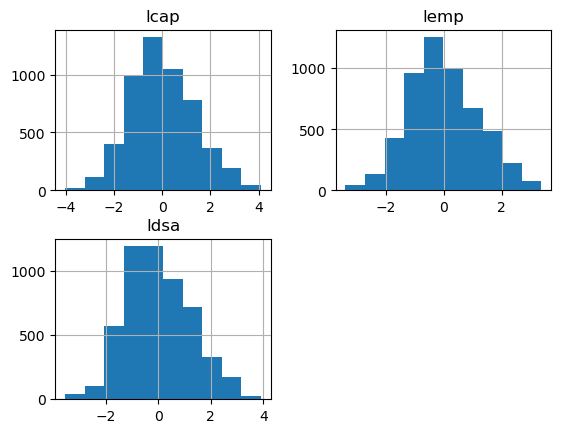

In [9]:
dat[['lcap','lemp','ldsa']].hist(); 

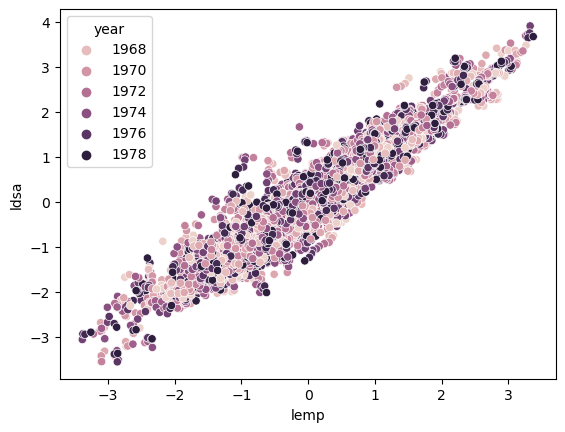

In [10]:
sns.scatterplot(x='lemp', y='ldsa', hue='year', data=dat); 

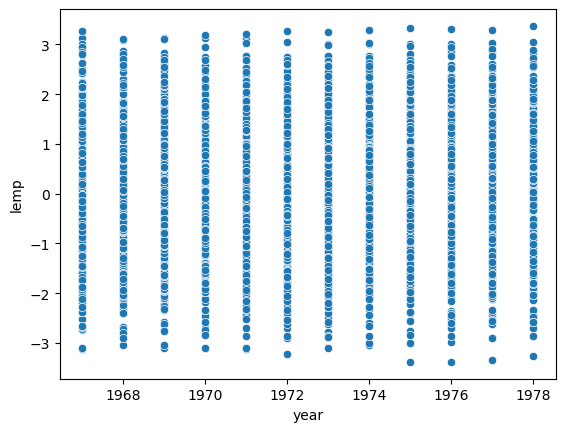

In [11]:
sns.scatterplot(x='year', y='lemp', data=dat); 

# Converting data to numpy format 

In [12]:
dat.ldsa.values.shape

(5292,)

In [13]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


Extract data from `pandas` to `numpy` arrays. 

In [14]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])

---

In [15]:
est_pols = lm.estimate(y,X, N=N, T=T)
label_y = 'Log of deflated sales'
label_x = ['Constant', 'Log employment', 'Log capital stock']

lm.print_table(labels=(label_y, label_x), results=est_pols, title='Pooled OLS', floatfmt='.4f')

Pooled OLS
Dependent variable: Log of deflated sales

                     Beta      Se    t-values
-----------------  ------  ------  ----------
Constant           0.0000  0.0050      0.0000
Log employment     0.6778  0.0101     67.3273
Log capital stock  0.3028  0.0090     33.5158
R² = 0.914
σ² = 0.130
DF=5289
N=441
T=12


---

### FE-estimation

---

In [16]:
def demeaning_matrix(T):
    Q_T = np.eye(T)-np.tile(1/T,T)
    return Q_T

In [17]:
Q_T = demeaning_matrix(T)
y_demean = lm.perm(Q_T, y)
x_demean = lm.perm(Q_T,X)

In [18]:
x_demean.shape

(5292, 3)

In [19]:
#Checking the rank condition
lm.check_rank(x_demean)

'The matrix is NOT full rank with rank = 2. Eliminate linearly dependent columns.'

In [20]:
#We of course remove the constant column (only zeros)
x_demean = x_demean[:, 1:]
lm.check_rank(x_demean)

'The matrix is of full rank with rank = 2'

In [21]:
label_x_fe = label_x[1:]
label_x_fe

['Log employment', 'Log capital stock']

In [22]:
est_fe = lm.estimate(y=y_demean, x=x_demean, transform='fe', T=T, N=N)
lm.print_table(labels=(label_y, label_x_fe), results=est_fe, title='FE-estimation')

FE-estimation
Dependent variable: Log of deflated sales

                       Beta         Se    t-values
-----------------  --------  ---------  ----------
Log employment     0.696387  0.014402      48.3535
Log capital stock  0.142663  0.0124009     11.5043
R² = 0.492
σ² = 0.017
DF=4849
N=441
T=12


---

### FD-estimation

---

In [23]:
def fd_matrix(T):
    D_T = -np.eye(T)+np.eye(T, k=1)
    D_T = D_T[:-1, :]
    return D_T

D_T = fd_matrix(T)

y_diff = lm.perm(D_T, y)
x_diff = lm.perm(D_T,X)
x_diff = x_diff[:,1:]

lm.check_rank(x_diff)

'The matrix is of full rank with rank = 2'

In [24]:
x_label_fd = ['Log employment', 'Log capital stock']

In [25]:
est_fd = lm.estimate(y_diff, x_diff, transform='fd', T=T-1, N=N)
lm.print_table((label_y, x_label_fd), est_fd, title='FD-estimation', floatfmt='.4f')

FD-estimation
Dependent variable: Log of deflated sales

                     Beta      Se    t-values
-----------------  ------  ------  ----------
Log employment     0.5462  0.0177     30.8264
Log capital stock  0.0645  0.0182      3.5474
R² = 0.174
σ² = 0.014
DF=4849
N=441
T=11


---

# Test for serial correlation 

---

In [26]:
year = np.array(dat.year)

In [34]:
serial_corr = lm.serial_corr(y_diff, x_diff, T=T, N=N, year=year)
serial_corr_out =lm.outreg(serial_corr, var_labels=['$e_{t-1}$'], name='Serial Correlation')
print(pd.DataFrame(serial_corr_out)\
    .rename(index={'se':'', 'beta':''})\
    .fillna('.')\
    .to_latex())

\begin{tabular}{lll}
\toprule
          & {} & Serial Correlation \\
\midrule
\$e\_\{t-1\}\$ & {} &         -0.2141*** \\
          & {} &           (0.0145) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_11632\1195511377.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(serial_corr_out)\


---

# Test for strict exogeneity

---

In [33]:
#We lead log employment
label_x_fe_lead = label_x_fe + ['Log employment +1']

#We test for strict exogeneity
#Leaving out the constant column 
est_fe_lead = lm.strict_exo_test(y=y, x=X[:,1:], T=T, N=N, lead_var=l, year=year) 
lm.print_table(results=est_fe_lead, labels=(label_y, label_x_fe_lead), title='Exogeneity test', floatfmt='.4f')
exo_out =lm.outreg(est_fe_lead, var_labels=label_x_fe_lead, name='Strict exogeneity test')
print(pd.DataFrame(exo_out)\
    .rename(index={'se':'', 'beta':''})\
    .fillna('.')\
    .to_latex())

Exogeneity test
Dependent variable: Log of deflated sales

                     Beta      Se    t-values
-----------------  ------  ------  ----------
Log employment     0.5560  0.0226     24.6160
Log capital stock  0.1323  0.0129     10.2462
Log employment +1  0.1688  0.0218      7.7312
R² = 0.481
σ² = 0.016
DF=4407
N=441
T=11
\begin{tabular}{lll}
\toprule
                  & {} & Strict exogeneity test \\
\midrule
Log employment & {} &               0.556*** \\
                  & {} &               (0.0226) \\
Log capital stock & {} &              0.1323*** \\
                  & {} &               (0.0129) \\
Log employment +1 & {} &              0.1688*** \\
                  & {} &               (0.0218) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_11632\70037935.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(exo_out)\


### WHAT DOES THIS MEAN FOR THE EXOGENEITY ASSUMPTION?

---

# Making latex table

---

In [ ]:
series_pols = lm.outreg(est_pols, var_labels=label_x, name='POLS')
series_fe = lm.outreg(est_fe, var_labels=label_x_fe, name='FE')
series_fd = lm.outreg(est_fd, var_labels=x_label_fd, name='FD')

In [ ]:
#Merge our series on left - play around with 'right', if it makes sense for our variables
table1 = pd.merge(series_pols, series_fe, 'left', left_index=True, right_index=True)
table1 = pd.merge(table1, series_fd, 'left', left_index=True, right_index=True)

#Make our second index column empty for pretty latex table and fill NaN with '.', if not included in regression
table1=table1.rename(index={'se':'', 'beta':''}).fillna('.') 
print(table1.to_latex())

\begin{tabular}{lllll}
\toprule
                  & {} &       POLS &         FE &         FD \\
\midrule
Constant & {} &        0.0 &          . &          . \\
                  & {} &    (0.005) &          . &          . \\
Log employment & {} &  0.6778*** &  0.6964*** &  0.5462*** \\
                  & {} &   (0.0101) &   (0.0144) &   (0.0177) \\
Log capital stock & {} &  0.3028*** &  0.1427*** &  0.0645*** \\
                  & {} &    (0.009) &   (0.0124) &   (0.0182) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_7588\1016528693.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table1.to_latex())


### Testing the hypothesis 

$\mathcal{H_0:}~\beta_l+\beta_k=1$ (Constant returns to scale)

$\mathcal{H_A:}~\beta_l+\beta_k\neq1$ (The one-sided alternative)


### Wald statistics

To compute a linear hypothesis of some (more than one) coefficients, define: 

\begin{align*}
(\mathbf{R} \widehat{\boldsymbol{\beta}}-\mathbf{R} \boldsymbol{\beta})^{\prime}\left[\mathbf{R}(\mathbf{V} / N) \mathbf{R}^{\prime}\right]^{-1}(\mathbf{R} \widehat{\boldsymbol{\beta}}-\mathbf{R} \boldsymbol{\beta}) \stackrel{d}{\approx} \chi_Q^2
\end{align*}

$Z \equiv \mathbf{R} \widehat{\boldsymbol{\beta}}-\mathbf{R} \boldsymbol{\beta}$ and $Q$ equal to the degrees of freedom. 

Define a linear hypothesis: $\mathbf{R\beta=r}$. The test $\beta_l + \beta_k = 1$ corresponds to
$\mathbf{R}=\left[
    \begin{array}{ll}
    1 & 1 
    \end{array}\right]$ and $\mathbf{r=1}$.

Under $\mathcal{H_0}$, $\mathbf{R\beta=r}$.

In [ ]:
# Defining the matrix of which we test our K=2 regressors
R = np.array([1,1]).reshape(-1,1).T

#Collect our betas
beta_fd_mat = est_fd['b_hat'] #FD
beta_fe_mat = est_fe['b_hat'] #FE

#Define 'Z'
Z_fd = R@beta_fd_mat-1
Z_fe = R@beta_fe_mat-1

#Define our cov-matrix V
V_fd = est_fd['cov']
V_fe = est_fe['cov']

#Wald-stat that converges in distribution to chi^2, with Q degrees of freedom
chi_val_fd = Z_fd.T@np.linalg.inv(R@(V_fd/N)@R.T)@Z_fd
chi_val_fe = Z_fe.T@np.linalg.inv(R@(V_fe/N)@R.T)@Z_fe

#Compute p-values of our null hypothesis:
p_val_fd_hypo = chi2.sf(chi_val_fd.item(), est_fd['deg_of_frees']) #FD - using degrees from our results
p_val_fe_hypo = chi2.sf(chi_val_fe.item(), est_fe['deg_of_frees']) #FE - using degrees from our results

#save degrees of freedoms
fd_deg_of_frees = est_fd['deg_of_frees']
fe_deg_of_frees = est_fe['deg_of_frees']

#Print chi^2 stats and our p-values:
print(
    f'chi2_FD({fd_deg_of_frees})={chi_val_fd})', 
        'H_0 (FD) p-value:', p_val_fd_hypo, '\n'
    f'chi2_FE({fe_deg_of_frees})={chi_val_fe})',
        'H_0 (FE) p-value:', p_val_fe_hypo)

chi2_FD(4849)=[[122656.36098023]]) H_0 (FD) p-value: 0.0 
chi2_FE(4849)=[[74256.72034182]]) H_0 (FE) p-value: 0.0


# Addendum

Following code not included in assignment, just for sanity checks

---

### FE with time fixed effects

NB! From the assignment description, it seems that the cross-sectional mean has already been subtracted from the data. 
Can we even do FE then? 

---

In [ ]:
ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
year = dat.year.values.reshape((N*T,1))
X_time_fe=np.hstack((ones,l,k,year))

In [ ]:
dat.year.unique()

array([1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978], dtype=int64)

In [ ]:
dummy = np.eye(T, k=-1) #For T=time periods 
dummy = dummy[: , :-1] #Rule out due to dummy trap
dummy_dummy = np.tile(dummy, (N,1))
print(dummy_dummy, '\n\n', dummy_dummy.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 

 (5292, 11)


In [ ]:
#x_demean_time_dum = np.hstack((x_demean,dummy_dummy))

x_demean_time_dum = lm.perm(Q_T, X_time_fe)
x_demean_time_dum = x_demean_time_dum[:, 1:3:]
x_demean_time_dum = np.hstack((x_demean_time_dum, dummy_dummy))
#x_demean_time_dum = np.hstack((x_demean_time_dum[0, 1:], dummy_dummy))
label_x_fe_time = ['Log employment', 'Log capital stock', 
'1968', '1969', '1970', '1971', '1972', 
'1973', '1974', '1975', '1976', '1977', '1978']

In [ ]:
x_demean_time_dum.shape

(5292, 13)

In [ ]:
pd.DataFrame(x_demean_time_dum, columns=label_x_fe_time).head()

,Log employment,Log capital stock,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978
0,0.025516,0.135761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.053513,0.094463,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.054420,0.021075,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.030564,-0.024522,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.022177,-0.061041,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
lm.check_rank(x_demean_time_dum)

'The matrix is of full rank with rank = 13'

In [ ]:
est_fe_time = lm.estimate(y=y_demean, x=x_demean_time_dum, transform='fe', T=T, N=N)
lm.print_table(labels=(label_y, label_x_fe_time), results=est_fe_time, title='Time FE estimation')

Time FE estimation
Dependent variable: Log of deflated sales

                           Beta          Se      t-values
-----------------  ------------  ----------  ------------
Log employment      0.696387     0.0144184   48.2986
Log capital stock   0.142663     0.012415    11.4912
1968               -1.024e-07    0.00630055  -1.62525e-05
1969                6.76665e-08  0.00630055   1.07398e-05
1970                5.92738e-08  0.00630055   9.40773e-06
1971               -9.89383e-08  0.00630055  -1.57031e-05
1972               -6.75207e-08  0.00630055  -1.07166e-05
1973               -1.73717e-07  0.00630055  -2.75718e-05
1974                1.36027e-07  0.00630055   2.15897e-05
1975                3.17182e-08  0.00630055   5.0342e-06
1976                6.68997e-08  0.00630055   1.06181e-05
1977                7.03834e-08  0.00630055   1.1171e-05
1978               -8.05727e-08  0.00630055  -1.27882e-05
R² = 0.492
σ² = 0.018
DF=4838
N=441
T=12


---

Random effects (NB! should not be in assignment 1, probably...)

---

### Between Estimator

In [ ]:
def between_mat(T):
    P_T = np.tile(1/T, (1,T))
    return P_T
P_T = between_mat(T)

In [ ]:
y_be = lm.perm(P_T, y)
x_be = lm.perm(P_T, X)
lm.check_rank(x_be)

'The matrix is of full rank with rank = 3'

In [ ]:
est_be = lm.estimate(y=y_be, x=x_be, transform='be', T=T, N=N)
lm.print_table(labels=(label_y, label_x), results=est_be, title='BE-estimator')

BE-estimator
Dependent variable: Log of deflated sales

                          Beta         Se      t-values
-----------------  -----------  ---------  ------------
Constant           2.87389e-08  0.0161038   1.78461e-06
Log employment     0.669482     0.0340281  19.6744
Log capital stock  0.312461     0.0305549  10.2262
R² = 0.924
σ² = 0.114
DF=438
N=441
T=12


In [ ]:
from math import sqrt

sigma2_u = est_fe['sigma'] # fill in
sigma2_c = est_be['sigma']-1/T*est_fe['sigma'] # fill in
_lambda = 1-sqrt(sigma2_u/(sigma2_u+T*sigma2_c)) # fill in
print(_lambda)

0.8871848347640463


Since we have to use $\hat{\lambda}$ to quasi-demean within each individual, we again use the `perm` function. This time, we pass it the following transformation matrix,

$$
\mathbf{C}_{T}:=\mathbf{I}_{T} - \hat{\lambda}\mathbf{P}_{T},
$$

where $\mathbf{P}_{T}$ is the $1 \times T$ transformation vector we used earlier to calculate the mean of each person.

In [ ]:
def quasi_demean_mat(T, _lambda):
    P_T = between_mat(T)
    C_T = np.eye(T)-_lambda*P_T
    return C_T
C_T = quasi_demean_mat(T, _lambda)

In [ ]:
y_re = lm.perm(C_T, y)
x_re = lm.perm(C_T, X) 
lm.check_rank(x_re)

'The matrix is of full rank with rank = 3'

In [ ]:
est_re = lm.estimate(y=y_re, x=x_re, transform='re', T=T, N=N)
print(lm.print_table(labels=(label_y, label_x), results=est_re), 'lambda=',_lambda)

Results
Dependent variable: Log of deflated sales

                          Beta         Se      t-values
-----------------  -----------  ---------  ------------
Constant           2.74622e-08  0.0162257   1.69252e-06
Log employment     0.723451     0.0129053  56.0583
Log capital stock  0.185157     0.0113065  16.3762
R² = 0.649
σ² = 0.018
DF=5289
N=441
T=12
None lambda= 0.8871848347640463
